In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import glob
import pickle
from IPython.display import HTML
from moviepy.editor import VideoFileClip
%matplotlib inline

# Step 0: Camera Calibration

calibration image 1:  True
calibration image 2:  True
calibration image 3:  True
calibration image 4:  True
calibration image 5:  True
calibration image 6:  True
calibration image 7:  False
calibration image 8:  True
calibration image 9:  True
calibration image 10:  False
calibration image 11:  True
calibration image 12:  True
calibration image 13:  True
calibration image 14:  True
calibration image 15:  True
calibration image 16:  True
calibration image 17:  True
calibration image 18:  False
calibration image 19:  True
calibration image 20:  True


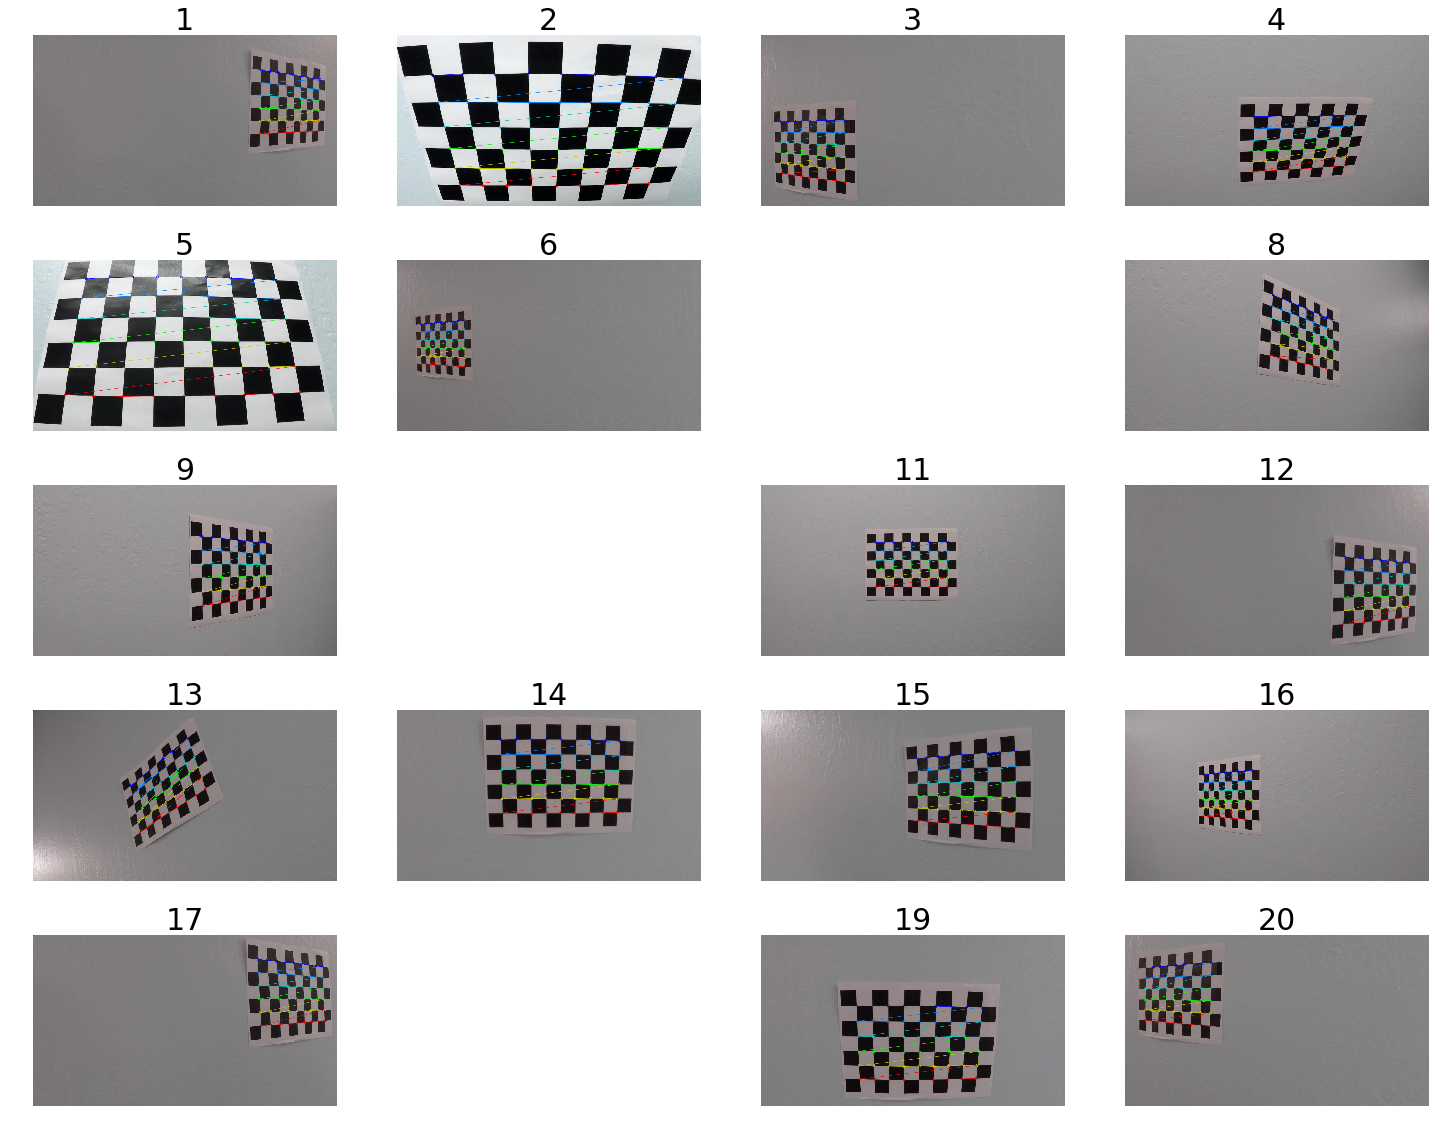

In [2]:
# Make a list of calibration images in the directory
images = glob.glob('camera_cal/calibration*.jpg')

# Prepare Object Points(Real-world), such as (0,0,0), (1,0,0), (2,0,0), ... , (8,5,0)
objp = np.zeros((6*9, 3), np.float32)
objp[ : , : 2] = np.mgrid[0:9, 0:6].T.reshape(-1,2) # (x=0:9, y=0:6, z=0) coordinates
# print("objp: \n", objp)

# Arrays to store object points and image points from all the images
object_points = [] # 3d points in real world space
image_points = [] # 2d points in image plane

figure = plt.figure(figsize=[25,20])


# Step through the list and search for chessboard corners
for idx, filename in enumerate(images):
    
    # read in images and convert to grayscale
    image = cv2.imread(filename)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    print("calibration image {}: ".format(idx+1), ret)
    
    # If corners found, add object points, image points
    if ret == True:
        object_points.append(objp)
        image_points.append(corners)
        
        # Draw and Display the corners
        cv2.drawChessboardCorners(image, (9,6), corners, ret)
        write_name = 'camera_cal/corners_found' + str(idx) +'.jpg' # save the images
        figure.add_subplot(5,4, idx+1)
        plt.imshow(image)
        plt.title(idx+1, fontsize=30)
        plt.axis('off')

image_size:  (1280, 720)


-1

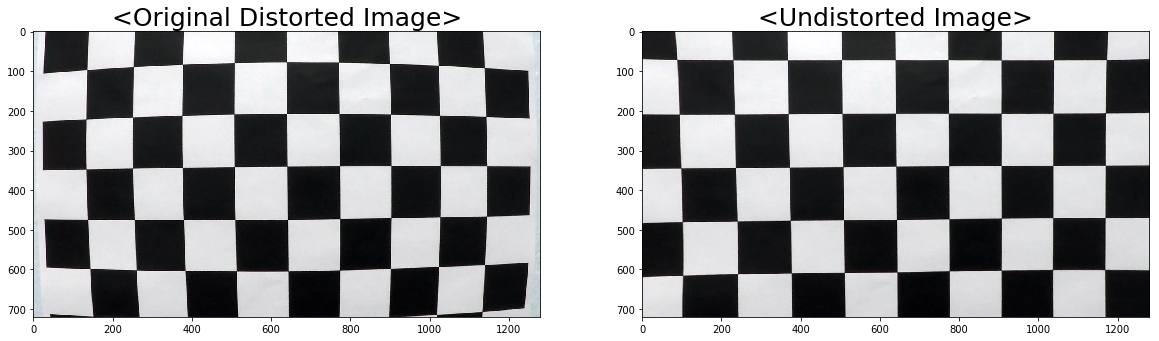

In [3]:
# Test undistortion on an image
distorted_image = cv2.imread('camera_cal/calibration1.jpg')
image_size = (distorted_image.shape[1], distorted_image.shape[0])
print("image_size: ", image_size)

# Calculate camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, image_size, None, None)

# Undistort the image
undistorted_image = cv2.undistort(distorted_image, mtx, dist, None, mtx)

# Save the camera calibration result for later use (No care about rvecs - rotation vectors , tvecs - translational vectors)
dist_pickle = {}
dist_pickle["mtx"] = mtx # camera matrix
dist_pickle["dist"] = dist # distortion coefficients
with open('calibration.p', 'wb') as f:
    pickle.dump(dist_pickle, f)

# Visualize undistortion
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(distorted_image)
ax1.set_title('<Original Distorted Image>', fontsize=25)
ax2.imshow(undistorted_image)
ax2.set_title('<Undistorted Image>', fontsize=25)
cv2.waitKey(500) #  wait for 500miliseconds till command

# Pipeline

In [4]:
class Calibration:
    def __init__(self, mtx, dist):
        self.__mtx = mtx
        self.__dist = dist
        
    @property
    def mtx(self):
        return self.__mtx
    
    @property
    def dist(self):
        return self.__dist
        
        
class Pipeline:
    def __init__(self, calibration):
        self.calibration = calibration
        
    # Helper functions
    def undistort(self, image):
        """Undistort the image given the calibration matrix and distortion coefficients"""
        undistorted_image = cv2.undistort(image, self.calibration.mtx, self.calibration.dist, None, self.calibration.mtx)
        return undistorted_image
    
    
    def hls(self, image, threshold = [170, 255]):
        """Extract S channel from HLS color space"""
        hls_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

        h_channel = hls_image[:, :, 0]
        l_channel = hls_image[:, :, 1]
        s_channel = hls_image[:, :, 2]
        
        # Create a copy and apply the threshold(binary image of ones where threshold is met, zeros otherwie)
        binary_image = np.zeros_like(s_channel)
        binary_image[(s_channel >= threshold[0]) & (s_channel <= threshold[1])] = 1
        
        return binary_image

    
    def lab(self, image, threshold = [150, 255]):
        """Extract b channel from Lab color space"""
        lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
        
        l_channel = lab_image[:, :, 0]
        a_channel = lab_image[:, :, 1]
        b_channel = lab_image[:, :, 2]
        
        # Create a copy and apply the threshold(binary image of ones where threshold is met, zeros otherwie)
        binary_image = np.zeros_like(b_channel)
        binary_image[((b_channel >= threshold[0]) & (b_channel < threshold[1]))] = 1
        
        return binary_image
        
        
    def color_threshold(self, image):
        """Extract S and b channels from image"""
        s_channel_threshold = self.hls(image)
        b_channel_threshold = self.lab(image)
        
        # Create a copy and apply the threshold(binary image of ones where threshold is met, zeros otherwie)
        color_composite = np.zeros_like(s_channel_threshold)
        color_composite[((s_channel_threshold == 1) | (b_channel_threshold == 1))] = 1
        
        return color_composite
    
    
    def sobel(self, image, kernel_size=9):
        """Calculate the Sobel in the X and Y directions"""
        sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=kernel_size)
        sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=kernel_size)

        return sobel_x, sobel_y
    
    
    def sobel_threshold(self, image, orientation = 'x', threshold = [30, 255]):
        """Calculate absolute Sobel threshold"""

        # Apply x or y gradient and take the absolute value
        if orientation == 'x':
            abs_sobel, _ = np.absolute(self.sobel(image))
        else:
            _, abs_sobel = np.absolute(self.sobel(image))
            
        # Rescale back to 8 bit integer
        scale_factor = np.max(abs_sobel)/255
        scaled_sobel = np.uint8(abs_sobel/scale_factor)
#         scaled_sobel = np.uint8(np.multiply(255, abs_sobel) / np.max(abs_sobel))
        
        # Create a copy and apply the threshold(binary image of ones where threshold is met, zeros otherwie)
        binary_image = np.zeros_like(scaled_sobel)
        binary_image[(scaled_sobel >= threshold[0]) & (scaled_sobel <= threshold[1])] = 1
        
        return binary_image
        
        
    def magnitude_threshold(self, image, sobel_kernel_size=9, threshold = [40, 200]):
        """Compute the magnitude of the gradient and applies a threshold"""
        
        # Take both Sobel x and y gradients
        sobel_x, sobel_y = self.sobel(image, kernel_size=sobel_kernel_size)
        
        # Calculate the gradient magnitude
        gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
#         gradient_magnitude = np.sqrt(np.square(sobel_x) + np.square(sobel_y))
        
        # Rescale to 8 bit
        scale_factor = np.max(gradient_magnitude)/255
        gradient_magnitude = np.uint8(gradient_magnitude/scale_factor)
#         scaling_factor = np.divide(np.max(gradient_magnitude), 255)
#         scaled_gradient = np.divide(gradient_magnitude, scaling_factor).astype(np.uint8)
        
        # Create a copy and apply the threshold(binary image of ones where threshold is met, zeros otherwie)
        binary_image = np.zeros_like(gradient_magnitude)
        binary_image[(gradient_magnitude >= threshold[0]) & (gradient_magnitude < threshold[1])] = 1
#         binary_image = np.zeros_like(scaled_gradient)
#         binary_image[(scaled_gradient >= threshold[0]) & (scaled_gradient <= threshold[1])] = 1
        
        return binary_image
        
        
    def directional_threshold(self, image, kernel_size=9, threshold = [0.5, np.pi/2]):
        """Compute the direction of the gradient and applies a threshold"""
        
        # Take both Sobel x and y gradients
        sobel_x, sobel_y = self.sobel(image, kernel_size=kernel_size)
        
        # Calculate the gradient direction (each absolute value and arctan)
        directional_gradient = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))
        
        # Create a copy and apply the threshold(binary image of ones where threshold is met, zeros otherwie)
        binary_image = np.zeros_like(directional_gradient)
        binary_image[(directional_gradient >= threshold[0]) & (directional_gradient < threshold[1])] = 1
        
        return binary_image
    
    
    def gradient_threshold(self, image):
        
        # Sobel x, y Gradients
        x_gradient = self.sobel_threshold(image, orientation='x', threshold = [30, 200])
        y_gradient = self.sobel_threshold(image, orientation='y', threshold = [30, 200])
        
        # Magnitude Gradients
        magnitude_threshold = self.magnitude_threshold(image, threshold = [50, 255])
        
        # Directional Gradients
        directional_gradient = self.directional_threshold(image, threshold = [0.7, np.pi/2])
        
        # Create a copy and apply the threshold(binary image of ones where threshold is met, zeros otherwie)
        gradient_composite = np.zeros_like(directional_gradient)
        gradient_composite[((x_gradient == 1 | (magnitude_threshold == 1)) & ((directional_gradient == 1) | (y_gradient == 1)))] = 1
        
        return gradient_composite
    
    
    def composite_threshold(self, gradient_threshold, color_threshold):
        """Combine the color and gradient thresholds"""
        
        # Create a copy and apply the threshold(binary image of ones where threshold is met, zeros otherwie)
        binary_image = np.zeros_like(gradient_threshold)
        binary_image[(gradient_threshold == 1) | (color_threshold == 1)] = 1
        
        return binary_image
        
        
    def warp(self, image):
        """Define calibration box in source (original) and destination (desired or warped) coordinates"""

        image_size = (image.shape[1], image.shape[0])
        
        # Four source coordinates
#         src = np.float32(
#                    [[570, 460],
#                     [720, 460],
#                     [1050, 720],
#                     [200, 720]])
#         src = np.float32(
#                    [[570, 460],
#                     [720, 460],
#                     [1250, 720],
#                     [20, 720]])

#         src = np.float32(
#                    [[500, 500],
#                     [800, 500],
#                     [1200, 700],
#                     [50, 700]])

        # Four desired coordinates
#         dst = np.float32(
#                    [[400, 0],
#                     [image.shape[1] - 400, 0],
#                     [image.shape[1] - 400, image.shape[0]],
#                     [400, image.shape[0]]])
        
#         dst = np.float32(
#                    [[0, 0],
#                     [image.shape[1] - 40, 0],
#                     [image.shape[1] - 40, image.shape[0]],
#                     [0, image.shape[0]]])
#         dst = np.float32(
#                    [[400, 200],
#                     [1000, 200],
#                     [1000, 600],
#                     [400, 600]])   
        dst = np.float32(
                   [[0, 0],
                    [1200, 0],
                    [1200, 720],
                    [0, 720]])   
    
        src = np.float32(
            [[500, 480],
             [810, 482],
             [1250, 720],
             [40, 720]])
        
#         dst = np.float32(
#             [[0, 0],
#              [1200, 0],
#              [1200, 720],
#              [0, 720]]) 
        
        # Compute the perspective transform, M
        M = cv2.getPerspectiveTransform(src, dst)
    
        # Compute the inverse transform by swapping the input parameters
        M_inv = cv2.getPerspectiveTransform(dst, src)
    
        # Create warped image - uses linear interpolation
        warped_image = cv2.warpPerspective(image, M, image_size, flags=cv2.INTER_LINEAR)
        
        return warped_image, M, M_inv
    
    
    def find_lane_pixels(self, warped_image, **kwargs):

        # Take a histogram of the bottm half of the image
        histogram = np.sum(warped_image[warped_image.shape[0]//3 : , : ], axis=0)
        
        # Create an output image to draw on and visualize the result
        output_image = np.dstack((warped_image, warped_image, warped_image))*255
        
        # Find the peack of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        quarter_point = np.int(midpoint/2) # use quarter_point in case there's local minima
        
        leftx_base = np.argmax(histogram[ : midpoint])
        rightx_base = np.argmax(histogram[midpoint : ]) + midpoint
        
#         leftx_base = np.argmax(histogram[quarter_point : midpoint]) + quarter_point
#         rightx_base = np.argmax(histogram[midpoint : (midpoint+quarter_point)]) + midpoint
        
        # HYPERPARAMETERS
        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(warped_image.shape[0]/nwindows)
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = warped_image.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Current positions to be updated later for each window in nwindows
        leftx_current = leftx_base
        rightx_current = rightx_base
        
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        
        # Step through the windows one by one
        for window in range(nwindows):
            
            # Identify window boundaries in x and y (and right and left)
            win_y_low = warped_image.shape[0] - (window + 1)*window_height
            win_y_high = warped_image.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            
            # Draw the windows on the visualization image
            cv2.rectangle(output_image, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0,255,0), 2)
            cv2.rectangle(output_image, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0,255,0), 2)
            
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
        
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
    
        return leftx, lefty, rightx, righty, output_image, histogram
    
    
    def measure_curvature_pixels(self, warped_image, lefty, righty, leftx, rightx):
        """Calculate the curvature of polynomial functions in PIXELS"""
        
        # FIt a second order polynomial in pixel space
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, warped_image.shape[0] - 1, warped_image.shape[0])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        # Choose maximum y-value corresponding to the bottom of the image (evaluation for radius of curvature)
        y_eval = np.max(ploty) # pixel-space
        
        # Calculation of R_curve (Formulation for radius of curvature)
        # Actually no need to calculate curvature in pixel-space
        left_curvature_p = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**(3/2))/np.absolute(2*left_fit[0])
        right_curvature_p = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**(3/2))/np.absolute(2*right_fit[0])
        
        return ploty, left_fitx, right_fitx, left_curvature_p, right_curvature_p

        
    def measure_curvature_real(self, lefty, righty, leftx, rightx, image):
        """Calculate the curvature of polynomial functions in METERS"""
        
        # image size (1280, 720))
        image_width = image.shape[0]
        image_height = image.shape[1]
        
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/image_height        
        xm_per_pix = 3.7/700
        
        # Fit new polynomials to x, y in world space
        left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, deg=2)
        right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, deg=2)
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, image.shape[0] - 1, image.shape[0])
        left_fitx_m = left_fit_m[0]*ploty**2 + left_fit_m[1]*ploty + left_fit_m[2]
        right_fitx_m = right_fit_m[0]*ploty**2 + right_fit_m[1]*ploty + right_fit_m[2]
        
        # Choose maximum y-value corresponding to the bottom of the image (evaluation for radius of curvature)
        y_eval = np.max(ploty)*ym_per_pix # Real-world conversion
        
        # Calculation of R_curve (Formulation for radius of curvature)
        left_curvature = ((1 + (2*left_fit_m[0]*y_eval + left_fit_m[1])**2)**(3/2)) / np.absolute(2*left_fit_m[0])
        right_curvature = ((1 + (2*right_fit_m[0]*y_eval + right_fit_m[1])**2)**(3/2)) / np.absolute(2*right_fit_m[0])
        center_curvature = np.mean([left_curvature, right_curvature])
        
        # Calculate vehicle center
        x_max = image.shape[1]*xm_per_pix
        y_max = image.shape[0]*ym_per_pix
        vehicle_center = x_max/2
        
        # Calculate lane center
        lane_left = left_fit_m[0]*y_max**2 + left_fit_m[1]*y_max + left_fit_m[2]
        lane_right = right_fit_m[0]*y_max**2 + right_fit_m[1]*y_max + right_fit_m[2]
        lane_center = (lane_left + lane_right)/2
        
        # Calculate the lateral offset between vehicle center and lane center
        lateral_offset = vehicle_center - lane_center
        
        return left_fitx_m, right_fitx_m, left_curvature, right_curvature, center_curvature, lateral_offset
    
    
    def draw_lane(self, warped_image, undistorted_image, inverse_matrix, ploty, left_fitx, right_fitx, 
                  left_curvature, right_curvature, center_curvature, lateral_offset):
        """Draw the lane onto the image and apply the text"""
        
        # Create an image to draw the lines on
        warp_zero = np.uint8(np.zeros_like(warped_image))
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        image_size = (color_warp.shape[1], color_warp.shape[0])
        
        # Recast the x and y points into usable format for cv2.fillpoly()
        left_points = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        right_points = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        left_and_right_points = np.hstack((left_points, right_points))
        
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([left_and_right_points]), (0, 255, 0))
        cv2.polylines(color_warp, np.int32([left_points]), isClosed=False, color=(255,0,255), thickness=20)
        cv2.polylines(color_warp, np.int32([right_points]), isClosed=False, color=(0,255,255), thickness=20)
#         cv2.polylines(color_warp, np.int32([left_points]), isClosed=False, color=(255,0,0), thickness=20)
#         cv2.polylines(color_warp, np.int32([right_points]), isClosed=False, color=(0,0,255), thickness=20)
        
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        new_warp = cv2.warpPerspective(color_warp, inverse_matrix, image_size)
        
        # Combine the result with the original image
        result = cv2.addWeighted(undistorted_image, 0.9, new_warp, 0.5, 0)
        
        # Font setup
        cv2.putText(result, 'Distance from center: {:.2f} m'.format(lateral_offset), (100, 80), fontFace = 16, \
                   fontScale=1.5, color=(200,255,155), thickness = 4)
        cv2.putText(result, 'Radius of Curvature: {} m'.format(int(center_curvature)), (120, 140), fontFace = 16, \
                   fontScale=1.5, color=(200,255,155), thickness = 4)
        
        return result

    
    def run(self, image):
        
        # Undistort the image
        undistorted_image = self.undistort(image)
                    
        gray = cv2.cvtColor(undistorted_image, cv2.COLOR_BGR2GRAY)
                    
        # Color thresholds
        color_threshold = self.color_threshold(undistorted_image)
        
        # Gradient threshold
        gradient_threshold = self.gradient_threshold(gray)
                    
        # Combine Color and Gradient threshold
        combined_threshold = self.composite_threshold(gradient_threshold, color_threshold)
                    
        # Warp the image
        warped_image, _, inverse_matrix = self.warp(combined_threshold)
        
        # Find the lane pixels
        leftx, lefty, rightx, righty, output_image, histogram = self.find_lane_pixels(warped_image)
        
        # Measure curvature in pixel space
        ploty, left_fitx, right_fitx, left_curvature_p, right_curvature_p = self.measure_curvature_pixels(warped_image, lefty, righty, leftx, rightx)
        
        # Measure curvature and the lateral offset in real world
        left_fitx_m, right_fitx_m, left_curvature, right_curvature, center_curvature, lateral_offset = self.measure_curvature_real(lefty, righty, leftx, rightx, image)
                    
        # Draw the lane lines
        output = self.draw_lane(warped_image, undistorted_image, inverse_matrix, ploty, left_fitx, right_fitx, 
                  left_curvature, right_curvature, center_curvature, lateral_offset)
                    
        return output
                    

In [5]:
# ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, (1280, 720), None, None)

calibration = Calibration(mtx=mtx, dist=dist)
pipeline = Pipeline(calibration)

test_images = glob.glob('test_images/*.jpg')
images = []
print("test_images: ", test_images)
for path in test_images:
    print("path: ", path)
    image = cv2.imread(path)
    images.append({'image': image, 'path': path})
    
test_images = images

test_images:  ['test_images/test4.jpg', 'test_images/test5.jpg', 'test_images/straight_lines1.jpg', 'test_images/test1.jpg', 'test_images/test3.jpg', 'test_images/test6.jpg', 'test_images/test2.jpg', 'test_images/straight_lines2.jpg']
path:  test_images/test4.jpg
path:  test_images/test5.jpg
path:  test_images/straight_lines1.jpg
path:  test_images/test1.jpg
path:  test_images/test3.jpg
path:  test_images/test6.jpg
path:  test_images/test2.jpg
path:  test_images/straight_lines2.jpg


# Step1: Undistortion Images

Text(0.5,1,'<Undistorted Image>')

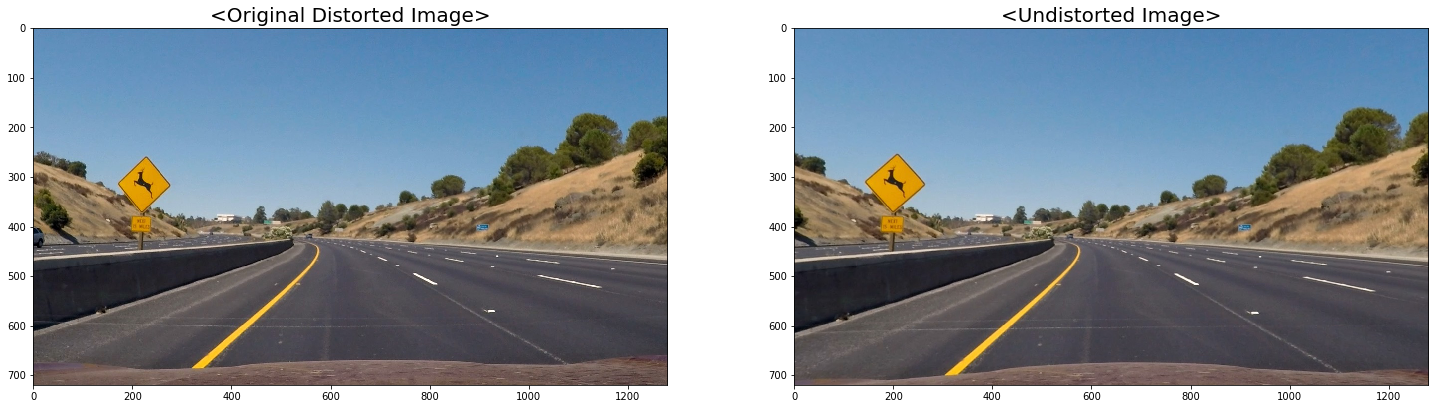

In [6]:
figure = plt.figure(figsize=[25, 25])

image = cv2.imread('test_images/test2.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Use distortion matrix to undistort image
dst = pipeline.undistort(image)
    
figure.add_subplot(1, 2, 1)
plt.imshow(image)
plt.title('<Original Distorted Image>', fontsize=20)
figure.add_subplot(1, 2, 2)
plt.imshow(dst)
plt.title('<Undistorted Image>', fontsize=20)

# Step2: Color and Gradient Thresholds

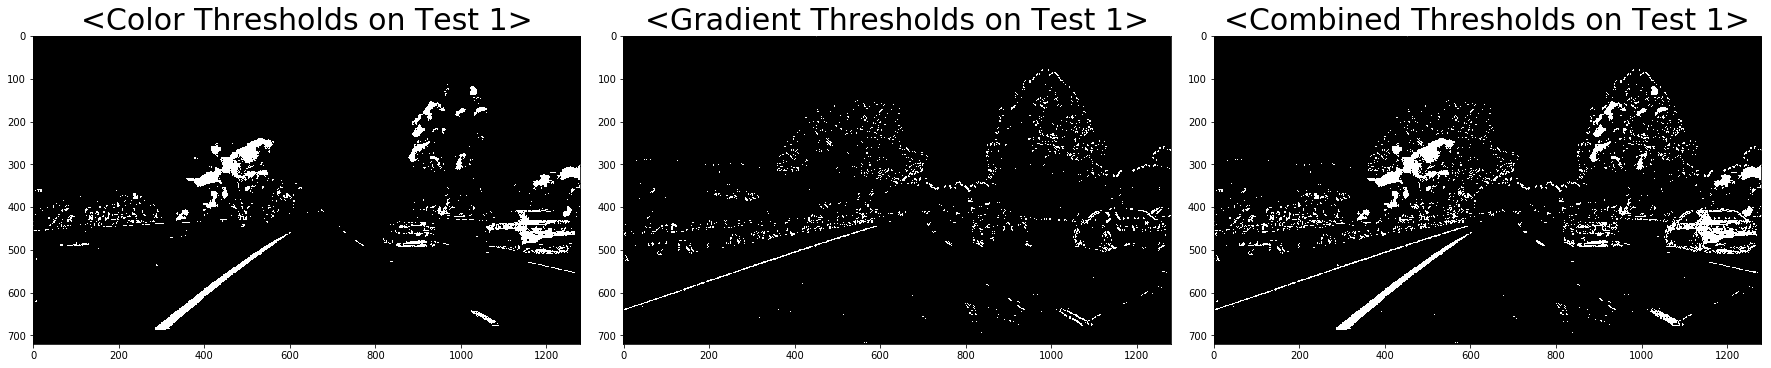

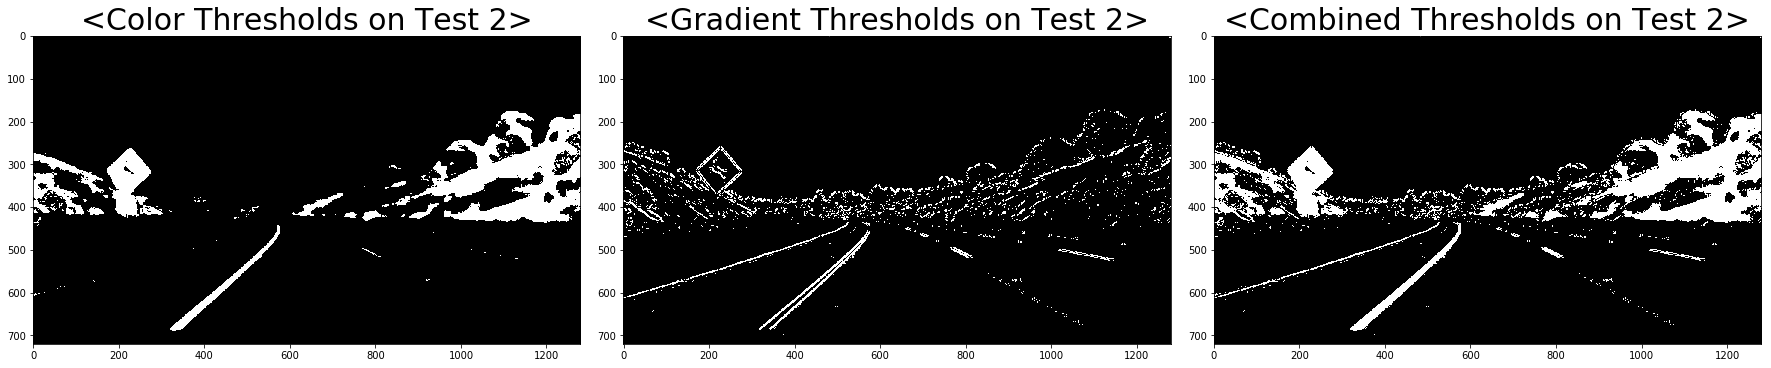

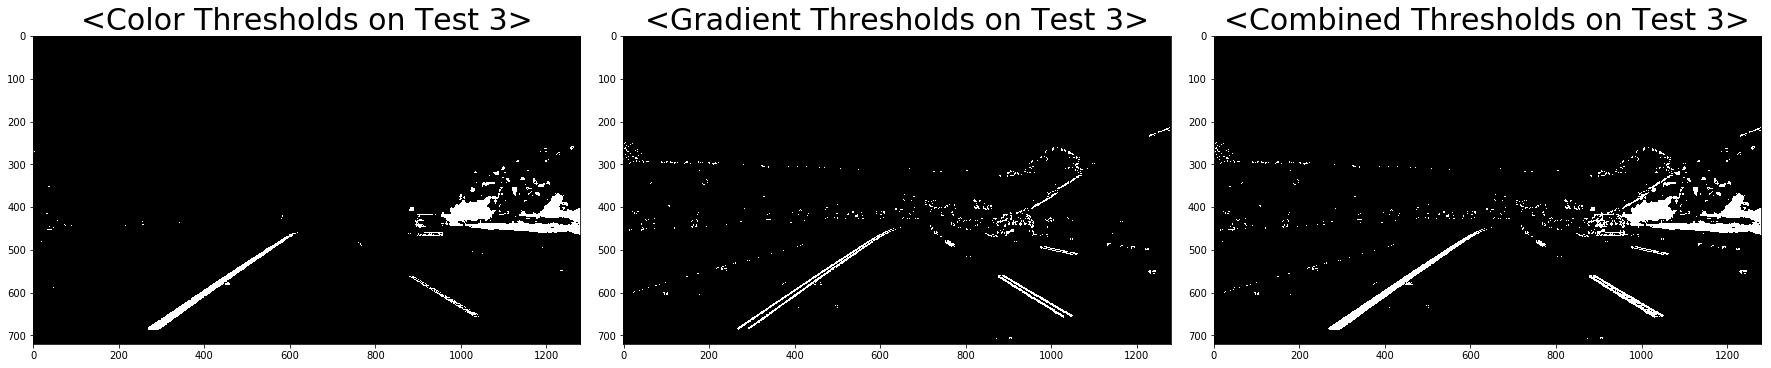

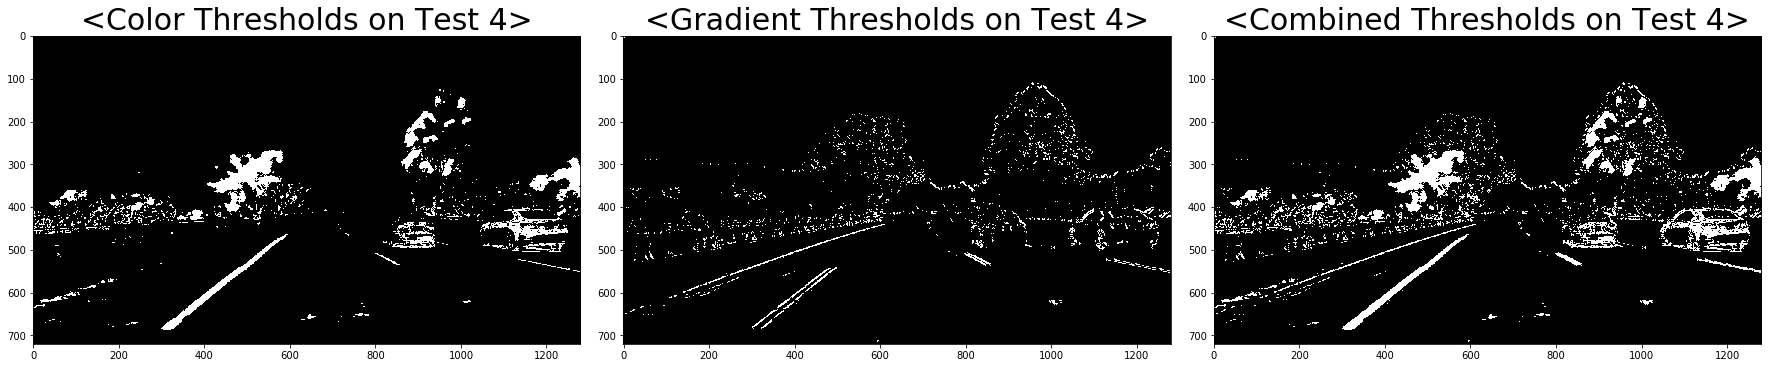

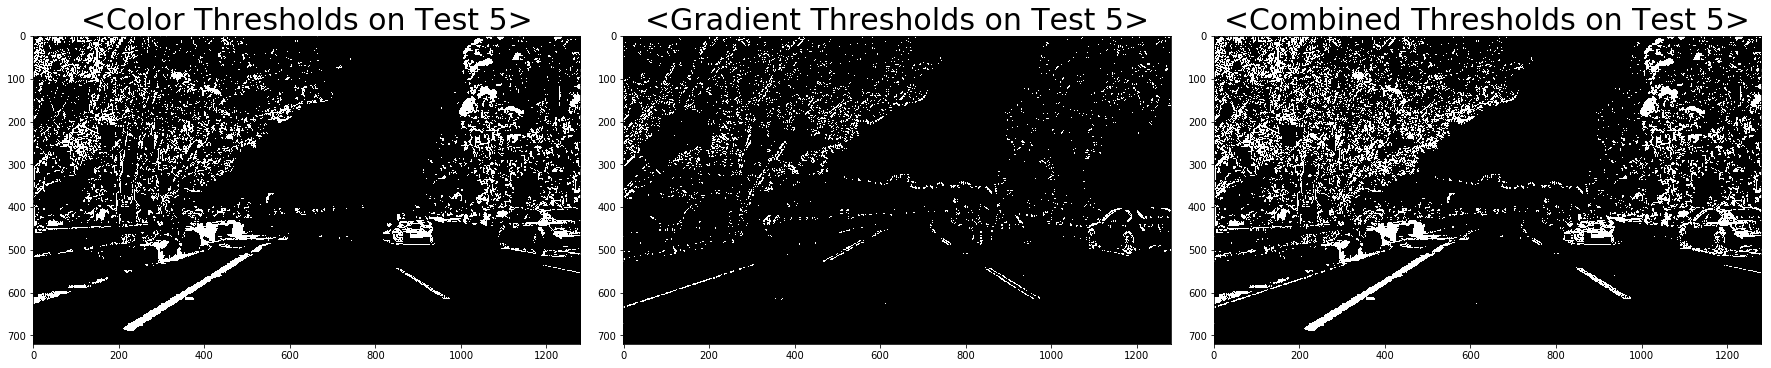

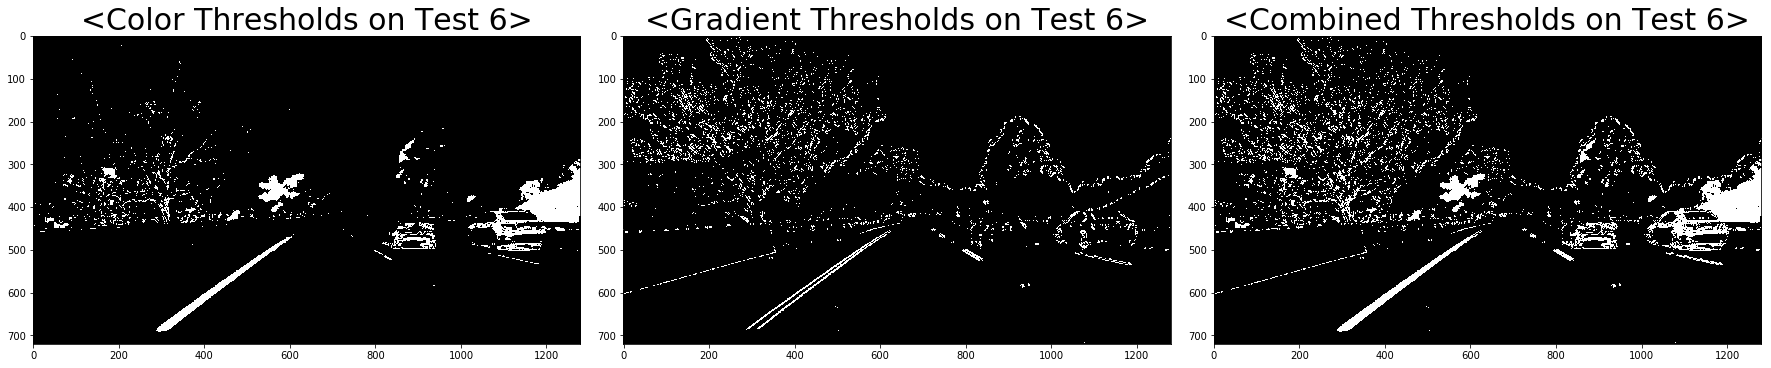

In [7]:
images, warped_images = [], []
color_thresholds = []
gradient_thresholds = []
composite_thresholds = []

# Read in some images
for index in range(6):
    image = cv2.imread("test_images/test{}.jpg".format(index+1))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(pipeline.undistort(image))
    
    color_threshold = pipeline.color_threshold(image)
    color_thresholds.append(color_threshold)
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gradient_threshold = pipeline.gradient_threshold(gray)
    gradient_thresholds.append(gradient_threshold)
                              
    composite_threshold = pipeline.composite_threshold(gradient_threshold, color_threshold)
    composite_thresholds.append(composite_threshold)                        
    
    
# figure = plt.figure(figsize=[20, 20])
for index, _ in enumerate(images):
    figure, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    figure.tight_layout()

    ax1.imshow(color_thresholds[index], cmap='gray')
    ax1.set_title('<Color Thresholds on Test {}>'.format(index+1), fontsize=30)
    
    ax2.imshow(gradient_thresholds[index], cmap='gray')
    ax2.set_title('<Gradient Thresholds on Test {}>'.format(index+1), fontsize=30)
    
    ax3.imshow(composite_thresholds[index], cmap='gray')
    ax3.set_title('<Combined Thresholds on Test {}>'.format(index+1), fontsize=30)
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    

# Step3: Perspective Transform

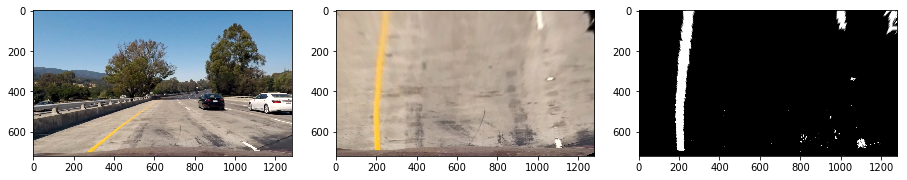

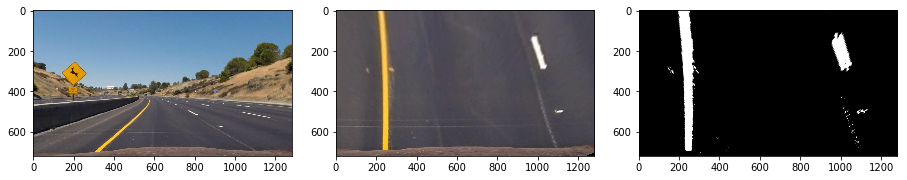

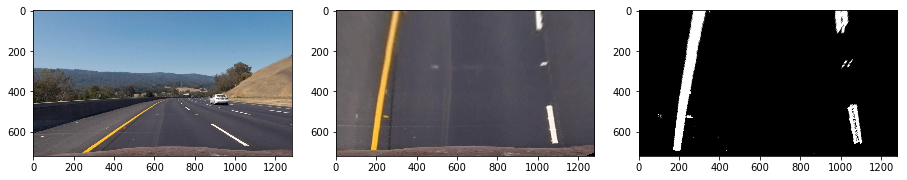

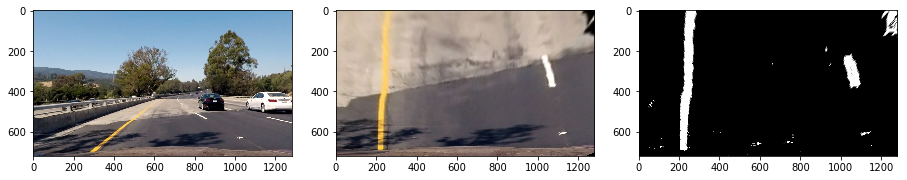

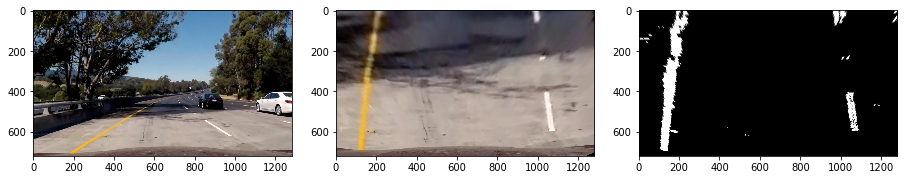

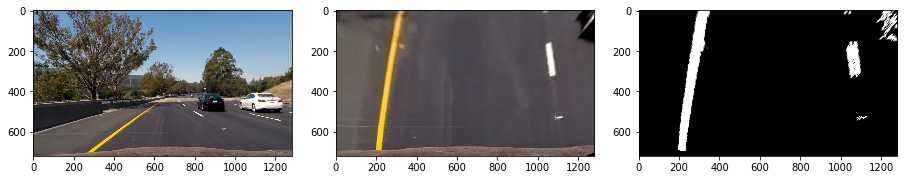

In [8]:
# figure = plt.figure(figsize=[20, 20])

images, warped_images1, warped_images2 = [], [], []


# Read in some images
for index in range(6):
    image = cv2.imread("test_images/test{}.jpg".format(index+1))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(pipeline.undistort(image))
    
#     # Transform perspective 
    warped_image1, _, _ = pipeline.warp(image)
    warped_images1.append(warped_image1)

    
    
    color_threshold = pipeline.color_threshold(image)
#     color_thresholds.append(color_threshold)
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gradient_threshold = pipeline.gradient_threshold(gray)
#     gradient_thresholds.append(gradient_threshold)
                              
    composite_threshold = pipeline.composite_threshold(gradient_threshold, color_threshold)
#     composite_thresholds.append(composite_threshold)  
    
    warped_image2, _, _ = pipeline.warp(composite_threshold)
    warped_images2.append(warped_image2)
    
    
# Plot the images
for index, _ in enumerate(images):
#     figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    figure, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
    figure.tight_layout()

    ax1.imshow(images[index])
    ax2.imshow(warped_images1[index], cmap='gray')
    ax3.imshow(warped_images2[index], cmap='gray')
    
   
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Step4: Detect and Fit Lane Lines

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


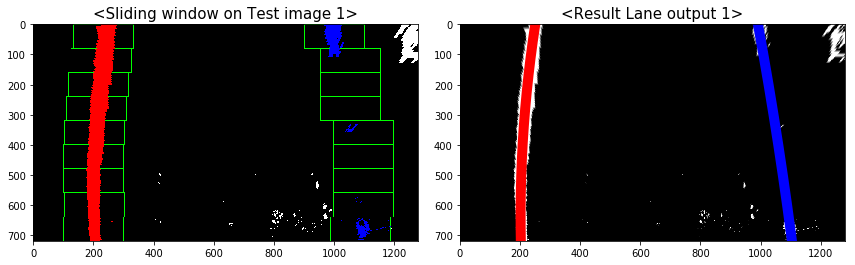

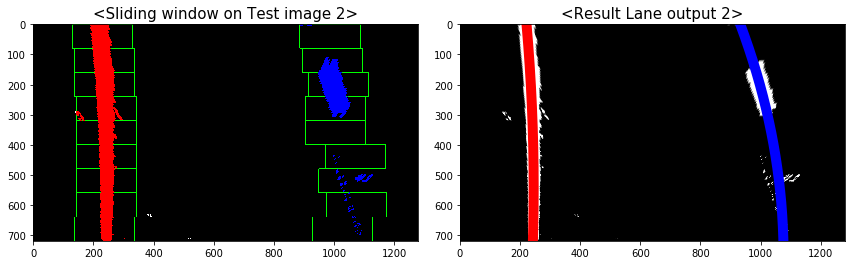

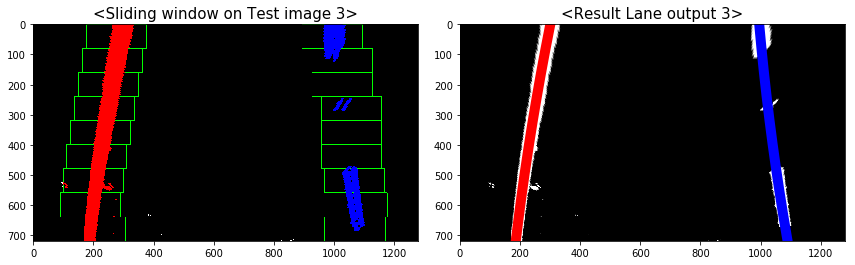

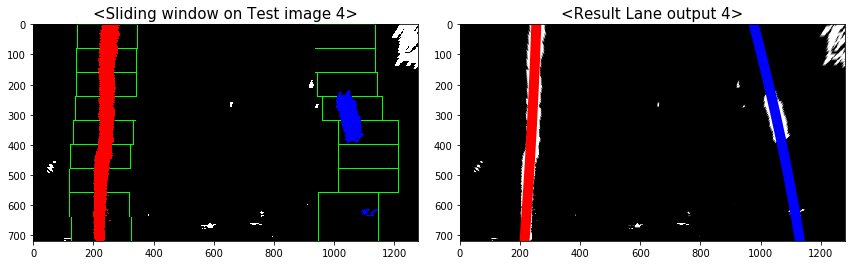

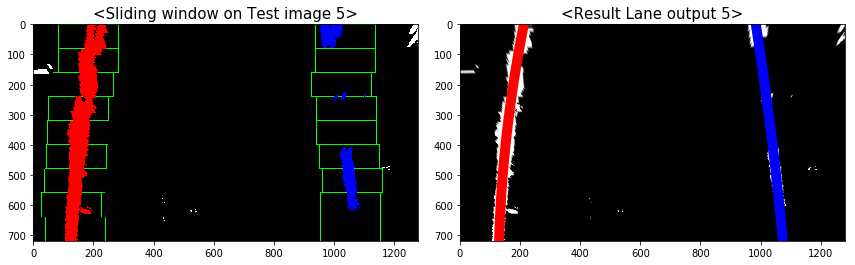

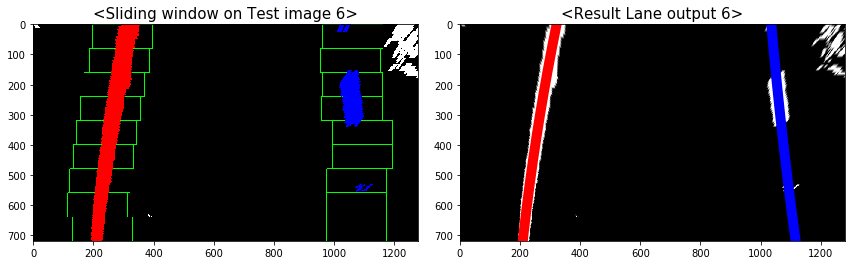

In [9]:
# Apply transformations 
for index, image in enumerate(images):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = pipeline.undistort(image)
    color_threshold = pipeline.color_threshold(image)
    gradient_threshold = pipeline.gradient_threshold(gray)
    composite_threshold = pipeline.composite_threshold(gradient_threshold, color_threshold)
    warped_image, _, _ = pipeline.warp(composite_threshold)

    leftx, lefty, rightx, righty, output_image, histogram = pipeline.find_lane_pixels(warped_image)
    
    
    ploty, left_fitx, right_fitx, left_curvature_p, right_curvature_p = pipeline.measure_curvature_pixels(warped_image, lefty, righty, leftx, rightx)
    
    output_image[lefty, leftx] = [255, 0, 0]
    output_image[righty, rightx] = [0, 0, 255]
    figure, (ax1, ax2) = plt.subplots(1, 2, figsize=[12,5])
    figure.tight_layout()
    ax1.imshow(output_image, cmap='gray')
    ax1.set_title('<Sliding window on Test image {}>'.format(index+1), fontsize=15)

    ax2.imshow(warped_image, cmap='gray')
    ax2.plot(left_fitx, ploty, color='red', linewidth=10)
    ax2.plot(right_fitx, ploty, color='blue', linewidth=10)
    ax2.set_title('<Result Lane output {}>'.format(index+1), fontsize=15)
    
    

(0, 1280)

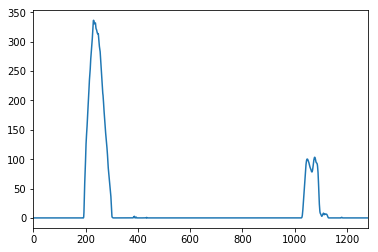

In [10]:
# Print histogram from sliding window polyfit for example image
plt.plot(histogram)
plt.xlim(0,1280)

# Step5: Curvature Estimation

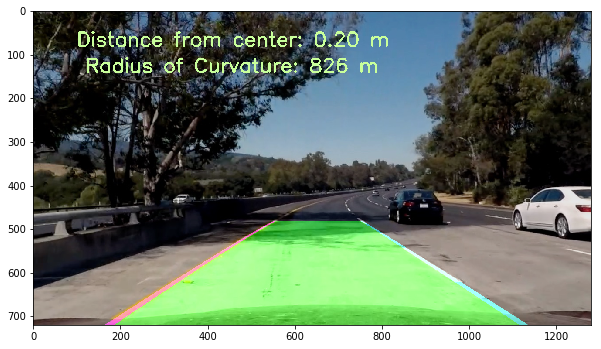

In [17]:
figure = plt.figure(figsize=[10, 10])

image = cv2.imread('test_images/test5.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

output_image  = pipeline.run(image)
# plt.title('<Output Image>', fontsize=30)
plt.imshow(output_image, cmap='gray')


# Step6: Processing with Videos

In [12]:
video_output = 'processed_video.mp4'
video_input = VideoFileClip("project_video.mp4")
processed_clip = video_input.fl_image(pipeline.run) # NOTE: this function expects color images!!
%time processed_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video processed_video.mp4
[MoviePy] Writing video processed_video.mp4


100%|█████████▉| 1260/1261 [06:48<00:00,  3.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: processed_video.mp4 

CPU times: user 16min 18s, sys: 2.2 s, total: 16min 20s
Wall time: 6min 48s


In [18]:
challenge_video_output = 'challenge_processed_video.mp4'
challenge_video_input = VideoFileClip("challenge_video.mp4")
processed_clip = challenge_video_input.fl_image(pipeline.run) # NOTE: this function expects color images!!
%time processed_clip.write_videofile(challenge_video_output, audio=False)

[MoviePy] >>>> Building video challenge_processed_video.mp4
[MoviePy] Writing video challenge_processed_video.mp4


100%|██████████| 485/485 [02:32<00:00,  3.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_processed_video.mp4 

CPU times: user 5min 59s, sys: 840 ms, total: 6min
Wall time: 2min 32s
